#General information

The goals of this lab is to use what we have learnt to build three models based on `VGG16` to solve a binary classification problem.

1. Data

   We have two folders: "training_set" and "test_set". In each folder, you have other two folders" "cats" and "dogs".

2. Models to build

*   `model1`: 

    - VGG16 without the top part (`base_model`) + your classifier. 

    - Freeze the `base_model` and set your classifier to trainable.

    - Train the network. Here, you basically train your classifier only.
 
*   `model2`: 

    - VGG16 without the top part (`base_model`) + your classifier. 

    - Train your classifier only (similar to what you have done in `model1`).

    - Unfreeze a few layers before your classifier. How many? Your choice.

    - Train the model again for a few more epochs with a small learning rate.

*   `model2`: 

    - VGG16 without the top part (`base_model`) + your classifier. 

    - Train your classifier only (similar to what you have done in `model1`).

    - Unfreeze the whole network.

    - Train the model again for a few more epochs with a small learning rate.


3. For each model,

    - show the training history and
    - show the performance on the test set.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/L6'

/content/drive/MyDrive/L6


In [ ]:
%cd 'test_set.zip (Unzipped Files)'

/content/drive/MyDrive/L6/test_set.zip (Unzipped Files)


In [5]:
train_data_dir = '/content/drive/MyDrive/L6/training_set.zip (Unzipped Files)/training_set'

In [6]:
test_data_dir = '/content/drive/MyDrive/L6/test_set.zip (Unzipped Files)/test_set'

In [ ]:
%cd '/content/drive/MyDrive/L6/training_set.zip (Unzipped Files)/training_set'

/content/drive/MyDrive/L6/training_set.zip (Unzipped Files)/training_set


In [7]:
#batch_size = 32
batch_size = 16
img_size=(224,224)


In [8]:
import tensorflow as tf

In [9]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir, shuffle=True, batch_size=batch_size, image_size=img_size)

Found 6516 files belonging to 2 classes.


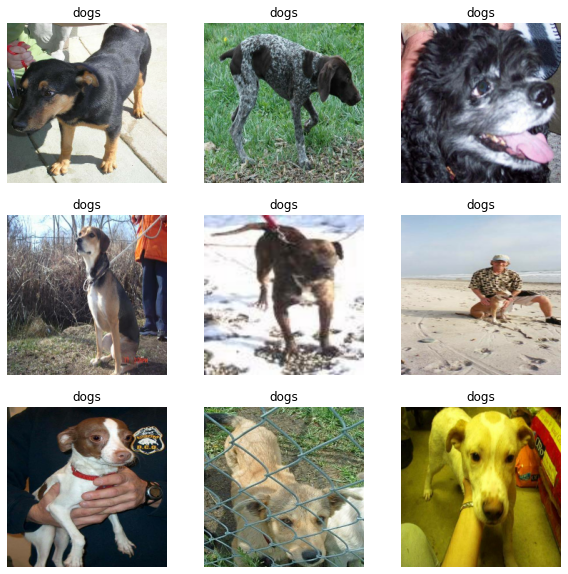

In [10]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
#Data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = "nearest",
    validation_split=0.2 #80-20 train-val split
)

In [12]:
img_height=224
img_width=224

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'training'
)

Found 5213 images belonging to 2 classes.


In [14]:
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'validation'
)

Found 1303 images belonging to 2 classes.


In [ ]:
#VGG16 pre-trained network
#model = VGG16()


In [15]:
base_model = tf.keras.applications.vgg16.VGG16(
  weights = "imagenet", # Load weights pre-trained on ImageNet.
  input_shape = (img_height, img_width, 3),
  include_top = False,
)

In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
len(base_model.layers)

19

##Model 1##
1. VGG16 without the top part (base_model) + your classifier.

2. Freeze the base_model and set your classifier to trainable.

3. Train the network. Here, you basically train your classifier only.

In [18]:
x = base_model.output

In [19]:
x = tf.keras.layers.Flatten()(x)

In [ ]:
#x = tf.keras.layers.Dense(1000, activation = 'relu')(x)

In [20]:
y_pred = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)

In [21]:
model = tf.keras.Model(inputs = base_model.input, outputs = y_pred)

In [22]:
for layer in model.layers[:len(base_model.layers)]:
  layer.trainable = False
for layer in model.layers[len(base_model.layers):]:
  layer.trainable = True

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

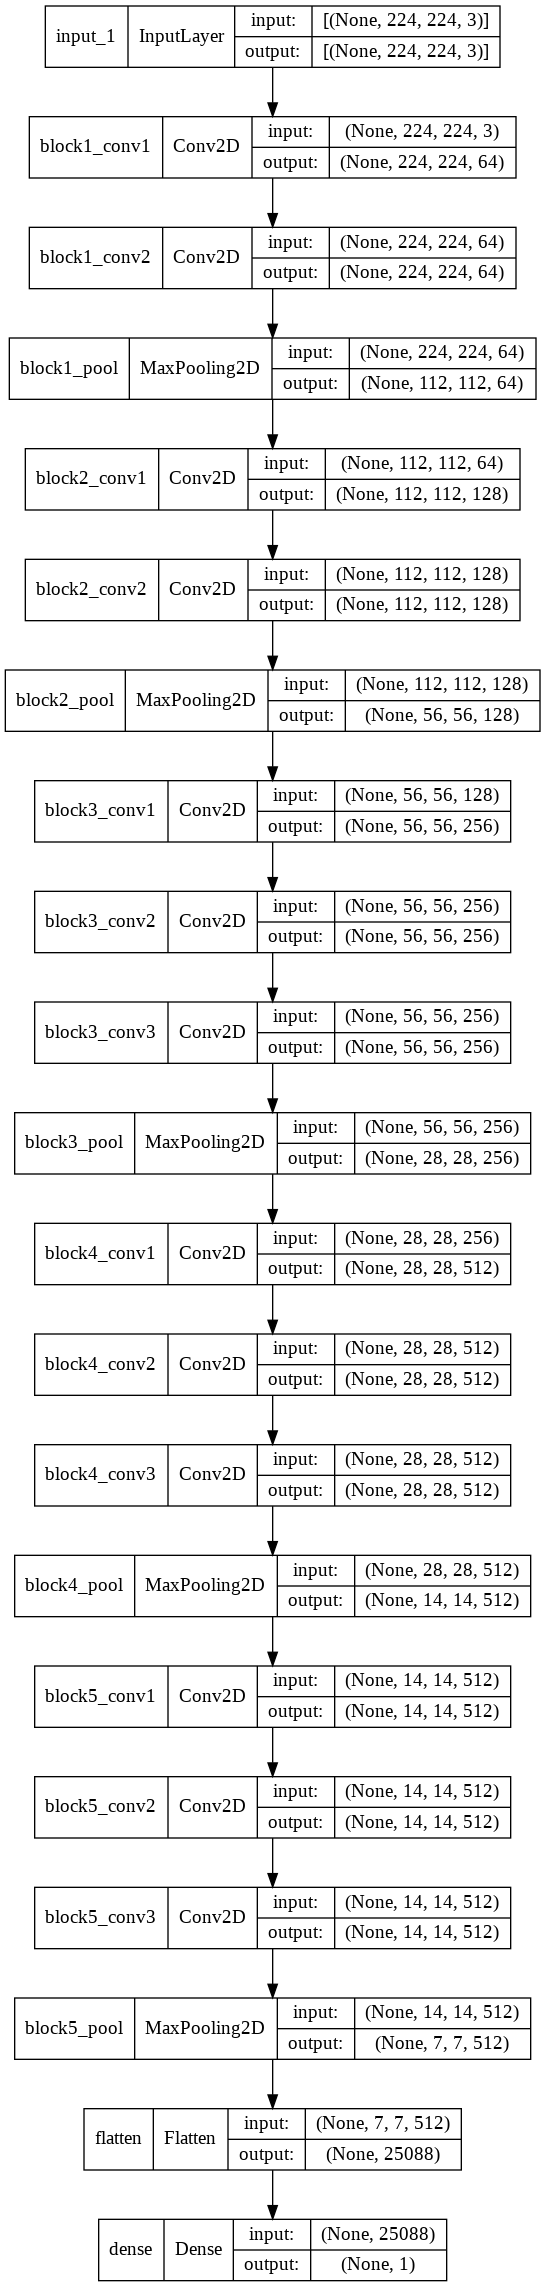

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [25]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    #epochs = 10,
    #steps_per_epoch = 10,
    epochs = 3,
    steps_per_epoch = 50,
    verbose = 1
)
#model.save('model1.h5', save_format='h5')

Epoch 1/3
50/50 [==============================] - 877s 18s/step - loss: 0.4988 - accuracy: 0.7738 - val_loss: 0.3505 - val_accuracy: 0.8480
Epoch 2/3
50/50 [==============================] - 279s 6s/step - loss: 0.3393 - accuracy: 0.8450 - val_loss: 0.3118 - val_accuracy: 0.8596
Epoch 3/3
50/50 [==============================] - 234s 5s/step - loss: 0.3437 - accuracy: 0.8444 - val_loss: 0.3352 - val_accuracy: 0.8442


In [26]:
model.save('modelcd_1.h5', save_format='h5')

In [27]:
%pwd


'/content'

In [28]:
train_loss, train_accuracy = model.evaluate(train_generator)

326/326 [==============================] - 1132s 3s/step - loss: 0.3175 - accuracy: 0.8582


In [30]:
val_loss, val_accuracy = model.evaluate(validation_generator)

82/82 [==============================] - 24s 287ms/step - loss: 0.3221 - accuracy: 0.8534


In [29]:
print(train_accuracy)

0.8582389950752258


In [31]:
print(val_accuracy)

0.8534151911735535


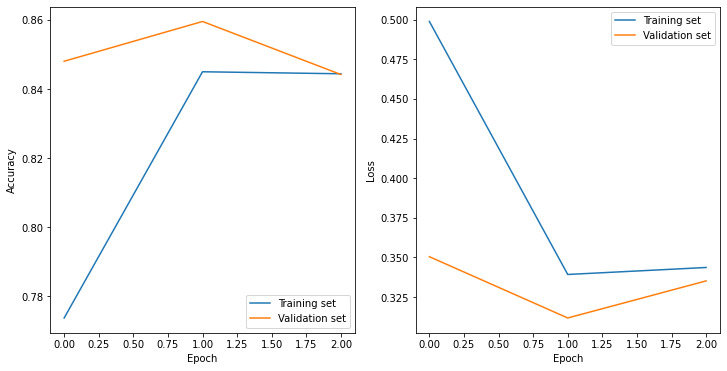

In [32]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Training set')
plt.plot(history.history['val_accuracy'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Training set')
plt.plot(history.history['val_loss'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

###Run on Test set###

##Test preparation##

1. Fetch test files via test_generator
2. Set shuffle = False to keep file indices 
3. Use model.evaluate to extract loss and accuracy
4. Extract classes information from test_generator (p)
5. Use model.predict to generate prediction output (q)
6. Set y_test = p.flatten and y_pred=q.flatten
7. Run confusion matrix and classification report to extract insights of model


In [33]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [35]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir, 
    target_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'binary',
    color_mode = 'rgb'

)

Found 3393 images belonging to 2 classes.


In [36]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [130]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [94]:
#predict = model.predict(test_generator)

In [131]:
type(predict)

numpy.ndarray

In [132]:
predict.shape

(3393, 1)

In [133]:
predict

array([[0.7114702 ],
       [0.706378  ],
       [0.7127352 ],
       ...,
       [0.69905674],
       [0.69905674],
       [0.6848578 ]], dtype=float32)

In [134]:
threshold = 0.5
predict_prob = np.where(predict > threshold, 1,0)

In [135]:
predict_prob.shape

(3393, 1)

In [136]:
y_test = np.array(test_generator.classes)


**Confusion matrix and classification report**

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

In [137]:
cm = confusion_matrix(y_test, predict_prob.flatten())
print(cm)

[[   0 1688]
 [   0 1705]]


In [138]:
print(classification_report(y_test, predict_prob))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1688
           1       0.50      1.00      0.67      1705

    accuracy                           0.50      3393
   macro avg       0.25      0.50      0.33      3393
weighted avg       0.25      0.50      0.34      3393



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
test_loss1, test_accuracy1 = model.evaluate(test_generator)

213/213 [==============================] - 29s 135ms/step - loss: 0.7813 - accuracy: 0.5025


In [ ]:
#print("Test Accuracy: ", test_accuracy)
#print("Test Loss: ", test_loss)

###Predict 1 random sample###

In [55]:
from IPython.display import Image, display

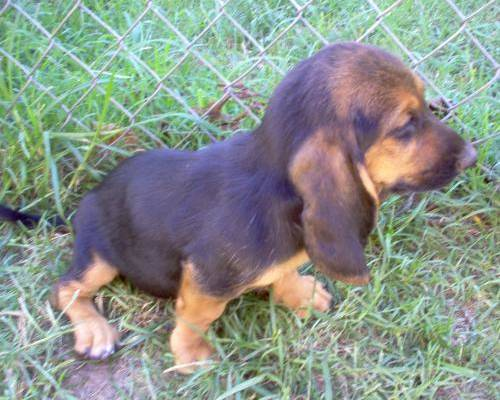

Prediction: dog


In [129]:
#predict 1 sample

#input a test image
test_img_path = '/content/drive/MyDrive/L6/test_set.zip (Unzipped Files)/test_set/dogs/dog.4009.jpg'

test_image = image.load_img(test_img_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
train_generator.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
display(Image(test_img_path))
print("Prediction:",prediction)

##Model 2##
1. VGG16 without the top part (base_model) + your classifier.

2. Unfreeze a few layers of the base_model.

3. Set your classifier to trainable.

In [57]:
x = base_model.output
x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(1000, activation = 'relu')(x)
y_pred2 = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)
model2 = tf.keras.Model(inputs = base_model.input, outputs = y_pred2)

In [58]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [59]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [60]:
history2 = model2.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 3,
    steps_per_epoch = 50,
    verbose = 1
)
model2.save('modelcd_2.h5', save_format='h5')

Epoch 1/3
50/50 [==============================] - 39s 765ms/step - loss: 0.5048 - accuracy: 0.7538 - val_loss: 0.5008 - val_accuracy: 0.7728
Epoch 2/3
50/50 [==============================] - 37s 750ms/step - loss: 0.4174 - accuracy: 0.8087 - val_loss: 0.4097 - val_accuracy: 0.8043
Epoch 3/3
50/50 [==============================] - 37s 756ms/step - loss: 0.3534 - accuracy: 0.8462 - val_loss: 0.2817 - val_accuracy: 0.8841


In [63]:
history2a = model2.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 5,
    steps_per_epoch = 50,
    verbose = 1
)
model2.save('modelcd_2a.h5', save_format='h5')

Epoch 1/5
50/50 [==============================] - 38s 764ms/step - loss: 0.2879 - accuracy: 0.8813 - val_loss: 0.3266 - val_accuracy: 0.8557
Epoch 2/5
50/50 [==============================] - 37s 758ms/step - loss: 0.3300 - accuracy: 0.8600 - val_loss: 0.3487 - val_accuracy: 0.8480
Epoch 3/5
50/50 [==============================] - 37s 752ms/step - loss: 0.2617 - accuracy: 0.8850 - val_loss: 0.2278 - val_accuracy: 0.9018
Epoch 4/5
50/50 [==============================] - 37s 749ms/step - loss: 0.2768 - accuracy: 0.8750 - val_loss: 0.2696 - val_accuracy: 0.8718
Epoch 5/5
50/50 [==============================] - 37s 753ms/step - loss: 0.2480 - accuracy: 0.9025 - val_loss: 0.2378 - val_accuracy: 0.9094


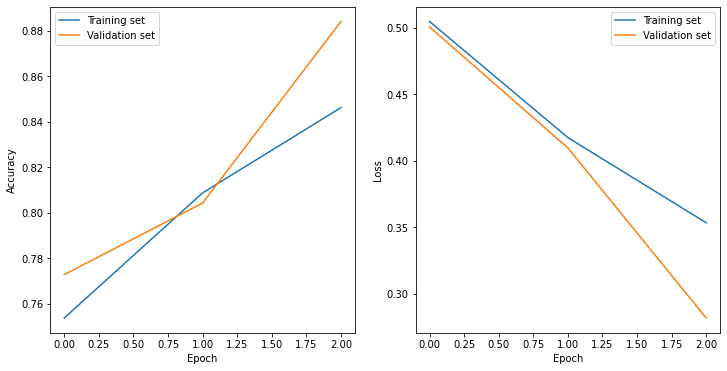

In [61]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label = 'Training set')
plt.plot(history2.history['val_accuracy'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label = 'Training set')
plt.plot(history2.history['val_loss'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

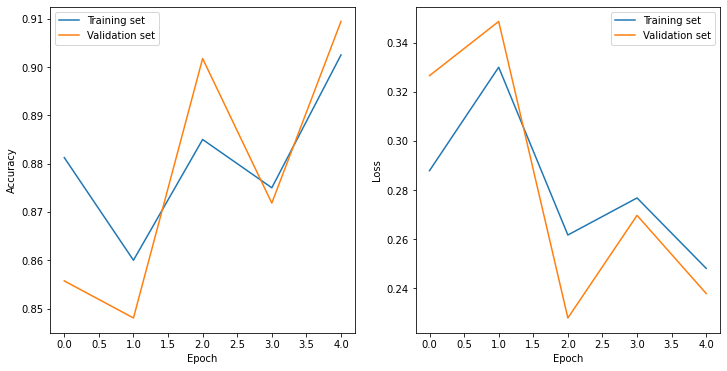

In [64]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.plot(history2a.history['accuracy'], label = 'Training set')
plt.plot(history2a.history['val_accuracy'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2a.history['loss'], label = 'Training set')
plt.plot(history2a.history['val_loss'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [65]:
test_loss2, test_accuracy2 = model2.evaluate(test_generator)

213/213 [==============================] - 29s 138ms/step - loss: 0.3059 - accuracy: 0.8739


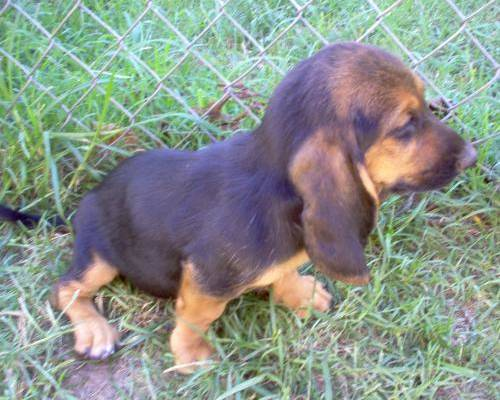

Prediction: dog


In [128]:
#predict 1 sample

#input a test image
test_img_path = '/content/drive/MyDrive/L6/test_set.zip (Unzipped Files)/test_set/dogs/dog.4009.jpg'

test_image = image.load_img(test_img_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model2.predict(test_image)
train_generator.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
display(Image(test_img_path))
print("Prediction:",prediction)

##Model 3##
1. VGG16 without the top part (base_model) + your classifier.

2. Unfreeze all layers of the base_model.

3. Set your classifier to trainable.

In [66]:
x = base_model.output
x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(1000, activation = 'relu')(x)
y_pred3 = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)
model3 = tf.keras.Model(inputs = base_model.input, outputs = y_pred2)

In [67]:
model3.trainable = True

In [68]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [69]:
history3 = model3.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 3,
    steps_per_epoch = 50,
    verbose = 1
)
model3.save('modelcd_3.h5', save_format='h5')

Epoch 1/3
50/50 [==============================] - 49s 901ms/step - loss: 27.7226 - accuracy: 0.6612 - val_loss: 0.5984 - val_accuracy: 0.7176
Epoch 2/3
50/50 [==============================] - 44s 890ms/step - loss: 0.5965 - accuracy: 0.7200 - val_loss: 0.6209 - val_accuracy: 0.7176
Epoch 3/3
50/50 [==============================] - 44s 884ms/step - loss: 0.5912 - accuracy: 0.7300 - val_loss: 0.5989 - val_accuracy: 0.7176


In [71]:
history3a = model3.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 5,
    steps_per_epoch = 50,
    verbose = 1
)
model3.save('modelcd_3a.h5', save_format='h5')

Epoch 1/5
50/50 [==============================] - 45s 895ms/step - loss: 0.6159 - accuracy: 0.7063 - val_loss: 0.5947 - val_accuracy: 0.7176
Epoch 2/5
50/50 [==============================] - 45s 896ms/step - loss: 0.6009 - accuracy: 0.7300 - val_loss: 0.5989 - val_accuracy: 0.7176
Epoch 3/5
50/50 [==============================] - 47s 937ms/step - loss: 0.6300 - accuracy: 0.7127 - val_loss: 0.6013 - val_accuracy: 0.7176
Epoch 4/5
50/50 [==============================] - 44s 886ms/step - loss: 0.5953 - accuracy: 0.7200 - val_loss: 0.5933 - val_accuracy: 0.7176
Epoch 5/5
50/50 [==============================] - 44s 892ms/step - loss: 0.5963 - accuracy: 0.7188 - val_loss: 0.6110 - val_accuracy: 0.7176


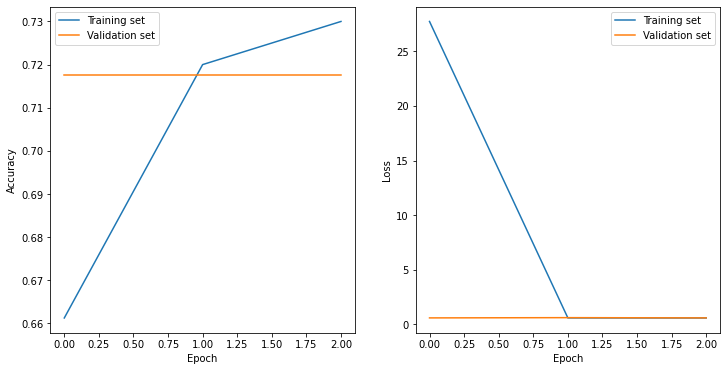

In [72]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'], label = 'Training set')
plt.plot(history3.history['val_accuracy'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label = 'Training set')
plt.plot(history3.history['val_loss'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

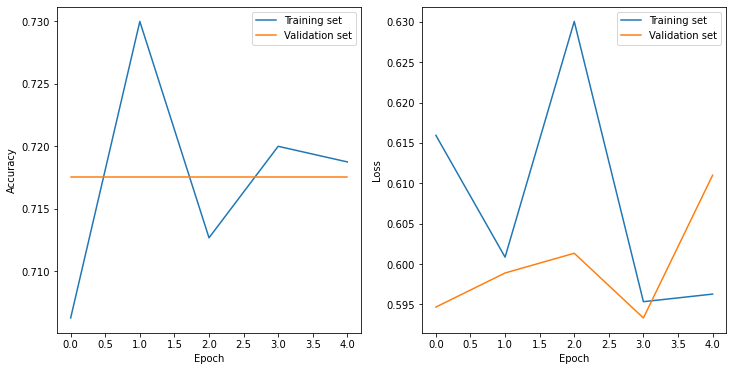

In [73]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.plot(history3a.history['accuracy'], label = 'Training set')
plt.plot(history3a.history['val_accuracy'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3a.history['loss'], label = 'Training set')
plt.plot(history3a.history['val_loss'], label = 'Validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [74]:
test_loss3, test_accuracy3 = model3.evaluate(test_generator)

213/213 [==============================] - 29s 135ms/step - loss: 0.7158 - accuracy: 0.5025


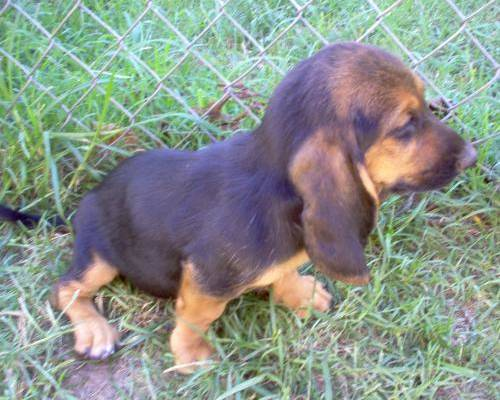

Prediction: dog


In [127]:
#predict 1 sample

#input a test image
test_img_path = '/content/drive/MyDrive/L6/test_set.zip (Unzipped Files)/test_set/dogs/dog.4009.jpg'

test_image = image.load_img(test_img_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model3.predict(test_image)
train_generator.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
display(Image(test_img_path))
print("Prediction:",prediction)

In [93]:
#Result tabulation
models = [('Model 1', test_loss1, test_accuracy1, 'Base Model + 1 output layer'),
          ('Model 2', test_loss2, test_accuracy2, 'Base Model (17-19 trainable) + 1 output layer'),
          ('Model 3', test_loss3, test_accuracy3, 'Base Model + 1 output layer (all trainable'),
         ]
summary = pd.DataFrame(data = models, columns=['Models', 'Test Loss', 'Test Accuracy','Comments'])
summary

,Models,Test Loss,Test Accuracy,Comments
0,Model 1,0.781341,0.502505,Base Model + 1 output layer
1,Model 2,0.305899,0.873858,Base Model (17-19 trainable) + 1 output layer
2,Model 3,0.715807,0.502505,Base Model + 1 output layer (all trainable


#Conclusion#

1. Model2 (Base + trainable layers) has the best performance in this experiment. Validation accuracy and test accuracy are in range of 88% (epoch=5).
2. It is also observed that the test accuracy of Model2 is similar to that of its training accuracy suggesting that the model has avoided overfitting.
3. Model 1 performs respectably in its training and validation, however it falters during testing. Possible reason of overfitting. However, further investigations are required.
4. Model 3 has an unresponsive validation accuracy graph, possibly due to the model having difficulty to learn or stucked at a local mimimum. Further experiments required.